## 2D Gaussian Process Regression on a Toy Function

This notebook demonstrates Gaussian Process (GP) regression on the 2D function `sin(x1) * sin(x2)`.

- **Top row:** A 1D slice at `x₂ ≈ π/2`, comparing:
  - MAP/ML estimate from Metropolis sampling
  - Numerical GP posterior (mean ± 2σ)
  - Analytical GP posterior (mean ± 2σ)
- **Bottom row:** 2D contour maps of the true function, numerical prediction, and analytical prediction.

The goal is to illustrate how Gaussian Processes extend naturally to higher-dimensional functions, providing both predictive means and uncertainty estimates.

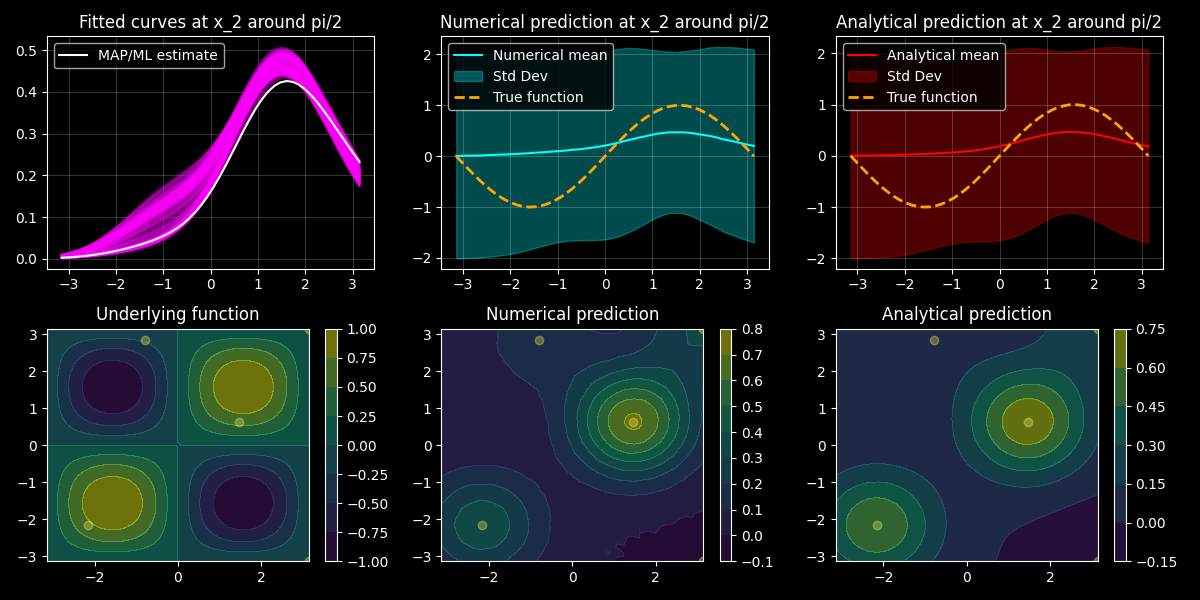  
plot after iteration 2

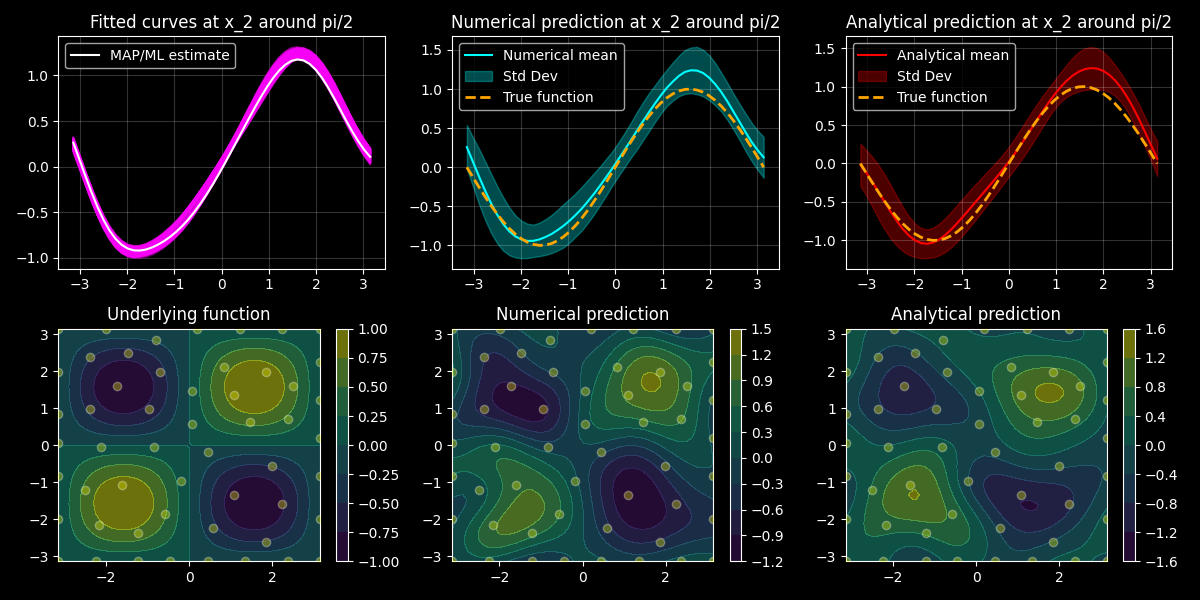
plot after final iteration (iteration 50)

In [21]:
import numpy as np
from math import e
from matplotlib import pyplot as plt
import time

plt.style.use('dark_background')
np.random.seed(42)

In [22]:
'''generate data, define variables'''
num_points = 3  # Original data points
num_x_test = 50  # Number of x_test per dimension
sigma_d_true = 0.2  # True standard deviation of noise in measured y
sigma_d = 0.1  # Guessed standard deviation of noise in measured y
sigma_k = 1  # Kernel
sigma_theta = 0.5  # Prior of theta
learning_rate = 0.00001
iterations = 10000
num_samples_metropolis = 300  # For Metropolis
step_size = 5e-5
threshold = 1e-10  # For removing small eigenvectors
num_samples_predictive_per_theta = 5  # Number of samples in MC approximation
alpha = 0.0001

def create_function(x, noiseless=False):
    y = np.sin(x[:, 0]) * np.sin(x[:, 1])  # True underlying 2d function
    if not noiseless:
        y += np.random.normal(0, sigma_d_true, size=x.shape[0])
    return y

# GenerateData
x_act = np.random.uniform(-np.pi, np.pi, (num_points, 2))
y_act = create_function(x_act)

In [23]:
# x_test grid for 2D
x1_test = np.linspace(-np.pi, np.pi, num_x_test)
x2_test = np.linspace(-np.pi, np.pi, num_x_test)
x1_test, x2_test = np.meshgrid(x1_test, x2_test)
x_test = np.column_stack((x1_test.ravel(), x2_test.ravel())) # first col is x_1, second col is x_2, same as x_act

In [24]:
'''define the RBF kernel function'''
def rbf_kernel(x_set_1, x_set_2, sigma_k):
    if np.ndim(x_set_2) == 1:
        x_set_2 = x_set_2.reshape(-1, 1)
    if np.ndim(x_set_1) == 1:
        x_set_1 = x_set_1.reshape(-1, 1)
    sq_dist = (np.array([x_set_1[:,0]]).T - np.array(x_set_2[:,0]))**2 + (np.array([x_set_1[:,1]]).T - np.array(x_set_2[:,1]))**2
    k_mat = np.exp(-sq_dist / (2 * sigma_k**2))
    return k_mat

Compute x_k: 0.0001 seconds
Compute metropolis: 0.0146 seconds
Compute bayesian marginalization: 0.1041 seconds
num is:  0

Compute x_k: 0.0000 seconds
Compute metropolis: 0.0150 seconds
Compute bayesian marginalization: 0.0909 seconds
num is:  1

Compute x_k: 0.0000 seconds
Compute metropolis: 0.0149 seconds
Compute bayesian marginalization: 0.0829 seconds


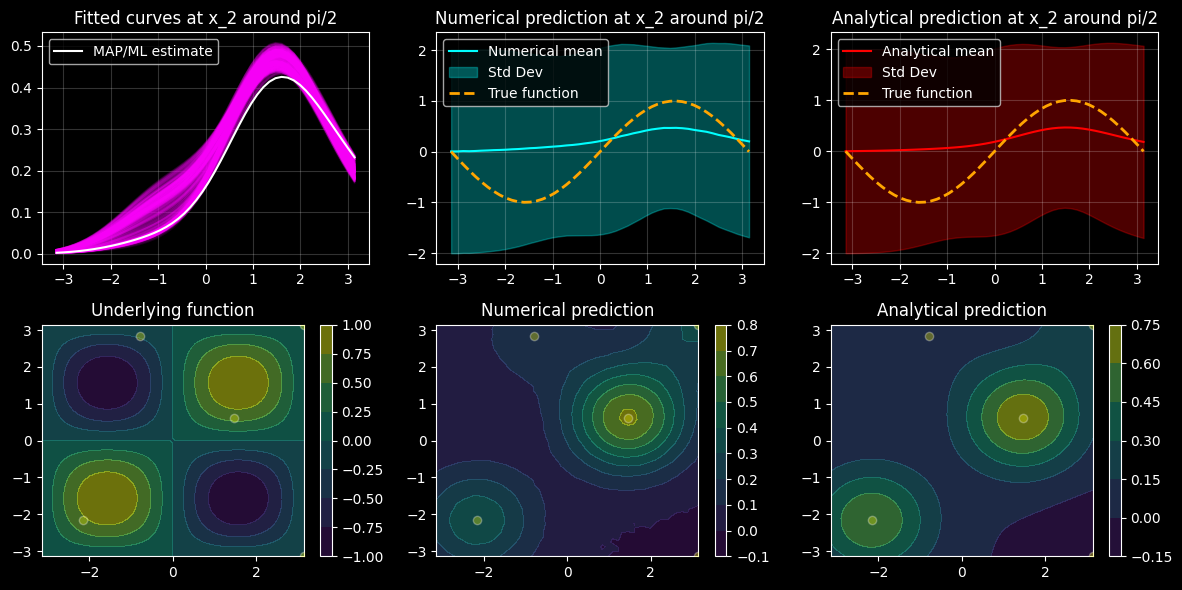

num is:  2

Compute x_k: 0.0001 seconds
Compute metropolis: 0.0147 seconds
Compute bayesian marginalization: 0.0836 seconds
num is:  3

Compute x_k: 0.0001 seconds
Compute metropolis: 0.0144 seconds
Compute bayesian marginalization: 0.0842 seconds
num is:  4

Compute x_k: 0.0001 seconds
Compute metropolis: 0.0179 seconds
Compute bayesian marginalization: 0.0837 seconds
num is:  5

Compute x_k: 0.0001 seconds
Compute metropolis: 0.0181 seconds
Compute bayesian marginalization: 0.0834 seconds
num is:  6

Compute x_k: 0.0001 seconds
Compute metropolis: 0.0180 seconds
Compute bayesian marginalization: 0.0847 seconds
num is:  7

Compute x_k: 0.0002 seconds
Compute metropolis: 0.0181 seconds
Compute bayesian marginalization: 0.0846 seconds
num is:  8

Compute x_k: 0.0002 seconds
Compute metropolis: 0.0190 seconds
Compute bayesian marginalization: 0.0852 seconds
num is:  9

Compute x_k: 0.0002 seconds
Compute metropolis: 0.0184 seconds
Compute bayesian marginalization: 0.0838 seconds
num is: 

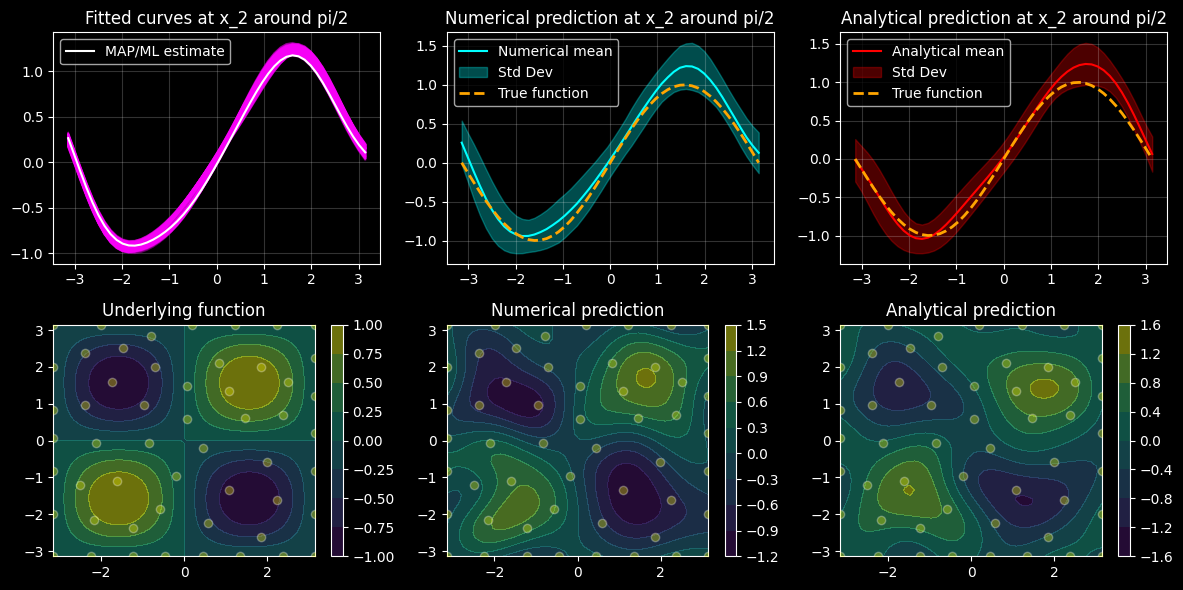

num is:  50



In [25]:
for num in range(51): # NOTE: adjust this value to change how many iterations run
    si = x_act.shape[0]
    found_sigma = np.sqrt(1 / (np.sum(x_act**2) + 1))

    '''finding x_k'''
    x_pre = []
    denom = 2 * sigma_k * sigma_k
    start_time = time.time()
    for counta in range(x_act.shape[0]):
        for countb in range(x_act.shape[0]):
            nume = (x_act[counta] - x_act[countb]) @ (x_act[counta] - x_act[countb])
            add = e**(-nume/denom)
            x_pre.append(add)
    print(f"Compute x_k: {time.time() - start_time:.4f} seconds")
    x_k = np.array(x_pre).reshape((si, si))


    '''eigen decompositio, finding phi_x'''
    eigenvalues, eigenvectors = np.linalg.eigh(x_k)
    threshold = 1e-10
    mask = eigenvalues > threshold
    eigenvalues = eigenvalues[mask]
    eigenvectors = eigenvectors[:, mask]
    phi_x = eigenvectors @ np.diag(np.sqrt(eigenvalues))


    '''find theta'''
    theta_ml = np.full(phi_x.shape[1], 1.)
    theta_ml = np.array([theta_ml])
    theta_ml = theta_ml.T


    '''gradient discent'''
    for i in range(10000):
        y_pred = np.dot(phi_x, theta_ml) # (5, 1)
        gradient = 2*(y_pred.reshape(-1)-y_act)
        gradient = (phi_x.T @ gradient).reshape(-1, 1)
        theta_ml -= alpha * gradient


    '''test'''
    x_pre2 = []
    denom2 = 2 * sigma_k * sigma_k
    for count1 in range(x_test.shape[0]):
        for count2 in range(x_act.shape[0]):
            nume2 = (x_test[count1] - x_act[count2]) @ (x_test[count1] - x_act[count2])
            add2 = e**(-nume2/denom2)
            x_pre2.append(add2)
    x_k_test = np.array(x_pre2).reshape((x_test.shape[0], si))
    phi_x_test = x_k_test @ eigenvectors @ np.diag(1 / np.sqrt(eigenvalues))
    y_pred2 = np.dot(phi_x_test, theta_ml)


    '''metropolis'''
    def prob_a(y_act, x_act, a_i, sigma_a, sigma_d):
        return e**(-np.sum(((y_act - x_act @ a_i)**2) / (2*sigma_d**2))) * e**(-np.sum(a_i**2)/sigma_a**2)
    num_theta_samples = 500
    num_samples = 1
    step_size = np.eye(theta_ml.shape[0]) * 5e-5
    sigma_a = sigma_theta
    samples = []
    prev_theta = theta_ml.reshape(-1)
    start_time = time.time()
    for i in range(num_theta_samples):
        next_theta = np.random.multivariate_normal(prev_theta, step_size) # (30, )
        r = prob_a(y_act, phi_x, next_theta, sigma_a, sigma_d) / prob_a(y_act, phi_x, prev_theta, sigma_a, sigma_d)

        if (r >= 1):
            samples.append(next_theta)
            prev_theta = next_theta
        elif(np.random.rand() <= r):
            samples.append(next_theta)
            prev_theta = next_theta
        else:
            samples.append(prev_theta)
    print(f"Compute metropolis: {time.time() - start_time:.4f} seconds")
    samples = np.array(samples)


    '''bayesian marginalization for numerical method'''
    posterior_mean_y = np.zeros(len(phi_x_test))
    posterior_var_y = np.zeros(len(phi_x_test))
    num_samples_predictive_per_theta = 5
    start_time = time.time()
    predictive_mean = phi_x_test @ samples.T
    predictive_var = sigma_d**2
    individual_pred_dist = np.random.normal(0, np.sqrt(predictive_var), (num_x_test**2, num_theta_samples, 5)) + predictive_mean.reshape(num_x_test**2, num_theta_samples, 1)
    individual_pred_dist = individual_pred_dist.reshape(num_x_test**2, -1)
    posterior_mean_y = np.mean(individual_pred_dist, axis=1)
    posterior_var_y = np.var(individual_pred_dist, axis=1)
    print(f"Compute bayesian marginalization: {time.time() - start_time:.4f} seconds")
    # This step transforms variance from feature space to original space
    k_star_star_diag = np.full((num_x_test**2,), 1)
    phi_samples_diag = np.sum((phi_x_test)**2, axis=1)
    posterior_var_y = posterior_var_y + k_star_star_diag - phi_samples_diag
    posterior_std_y = np.sqrt(posterior_var_y)
    '''bayesian marginalization for analytical method'''
    H_mat = x_k + np.eye(x_k.shape[0]) * sigma_d**2
    H_mat = (H_mat + H_mat.T) / 2 # for numerical stability
    H_mat += np.eye(H_mat.shape[0]) * 1e-6 # for numerical stability
    mean_1 = x_k_test @ np.linalg.inv(H_mat) @ y_act.T
    cov_mat_12 = x_k_test @ np.linalg.inv(H_mat)
    cov_mat_3 = np.sum(cov_mat_12 * x_k_test, axis=1)
    analytical_mean_y = mean_1.reshape(-1)
    analytical_std_y = np.sqrt((k_star_star_diag - cov_mat_3))

    if (num == 2 or num == 50 or num == 150): # NOTE: adjust this value to change how often plots are shown
        '''plot'''
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))

        # Second row: contour plots
        y_pred2 = y_pred2.reshape(-1)
        '''prep for plotting'''
        x1_test = x_test[:, 0].reshape(num_x_test, num_x_test)
        x2_test = x_test[:, 1].reshape(num_x_test, num_x_test)
        y_true = create_function(x_test, noiseless = True).reshape(num_x_test, num_x_test)

        matrix = phi_x_test @ samples.T
        x2_close_value = x_test[np.argmin(np.abs(x_test[:, 1] - np.pi/2)), 1]
        indices = np.where(x_test[:, 1] == x2_close_value)[0]
        x1_slice = x_test[indices, 0]
        true_function_slice = create_function(x_test[indices], noiseless=True)

        '''plot first row'''
        # Fitted Curves from Metropolis samples
        for sample in matrix[indices].T:
            axes[0, 0].plot(x1_slice, sample, color='magenta', alpha=0.1)
        v_samples_test = phi_x_test
        theta_map = theta_ml
        y_map = phi_x_test @ theta_ml
        axes[0, 0].plot(x1_slice, y_map[indices], color='white', linestyle='-', label='MAP/ML estimate')
        axes[0, 0].set_title('Fitted curves at x_2 around pi/2')
        axes[0, 0].legend(loc = 'upper left')
        axes[0, 0].grid(True, alpha=0.2)
        # Numerical Posterior
        mean_slice_num = posterior_mean_y[indices]
        std_slice_num = posterior_std_y[indices]
        axes[0, 1].plot(x1_slice, mean_slice_num, label='Numerical mean', color='cyan')
        axes[0, 1].fill_between(x1_slice, mean_slice_num - 2*std_slice_num, mean_slice_num + 2* std_slice_num, color='cyan', alpha=0.3, label='Std Dev')
        axes[0, 1].plot(x1_slice, true_function_slice,  color='orange', linestyle='--',label='True function', linewidth=2)
        axes[0, 1].set_title('Numerical prediction at x_2 around pi/2')
        axes[0, 1].legend(loc = 'upper left')
        axes[0, 1].grid(True, alpha=0.2)
                # Analytical Posterior
        mean_slice_ana = analytical_mean_y[indices]
        std_slice_ana = analytical_std_y[indices]
        axes[0, 2].plot(x1_slice, mean_slice_ana, label='Analytical mean', color='red')
        axes[0, 2].fill_between(x1_slice, mean_slice_ana - 2*std_slice_ana, mean_slice_ana + 2*std_slice_ana, color='red', alpha=0.3, label='Std Dev')
        axes[0, 2].plot(x1_slice, true_function_slice, color='orange', linestyle='--', label='True function', linewidth=2)
        axes[0, 2].set_title('Analytical prediction at x_2 around pi/2')
        axes[0, 2].legend(loc = 'upper left')
        axes[0, 2].grid(True, alpha=0.2)

        '''plot second row'''
        # Underlying function
        axes[1, 0].set_title('Underlying function')
        contour = axes[1, 0].contourf(x1_test, x2_test, y_true, cmap='viridis', alpha=0.5)
        fig.colorbar(contour, ax=axes[1, 0])
        axes[1, 0].scatter(x_act[:, 0], x_act[:, 1], color='yellow', label='Data points', alpha=0.3, edgecolors='w', zorder=10)
        # Numerical prediction
        axes[1, 1].set_title('Numerical prediction')
        contour = axes[1, 1].contourf(x1_test, x2_test, posterior_mean_y.reshape(num_x_test, num_x_test), cmap='viridis', alpha=0.5)
        axes[1, 1].scatter(x_act[:, 0], x_act[:, 1], color='yellow', label='Data points', alpha=0.3, edgecolors='w', zorder=10)
        fig.colorbar(contour, ax=axes[1, 1])
        # Analytical prediction
        axes[1, 2].set_title('Analytical prediction')
        contour = axes[1, 2].contourf(x1_test, x2_test, analytical_mean_y.reshape(num_x_test, num_x_test), cmap='viridis', alpha=0.5)
        axes[1, 2].scatter(x_act[:, 0], x_act[:, 1], color='yellow', label='Data points', alpha=0.3, edgecolors='w', zorder=10)
        fig.colorbar(contour, ax=axes[1, 2])
        
        plt.tight_layout()
        plt.show()

    '''find the x where the uncertainty is the largest'''
    uncertainty = np.array(analytical_mean_y - 2 * analytical_std_y) - (analytical_mean_y + 2 * analytical_std_y)
    max_x_uncertainty = np.max(np.abs(uncertainty))
    max_x_index = np.argmax(np.abs(uncertainty))
    # print(max_x_uncertainty)
    # print(max_x_index)
    x_new = np.array([x_test[max_x_index]])
    y_new = create_function(x_new)
    add1 = x_act.tolist()
    add2 = y_act.reshape(-1).tolist()
    x_new = x_new.reshape(-1)
    add1.append(x_new)
    add2.append(y_new[0])
    x_act = np.array(add1)
    y_act = np.array(add2)

    print('num is: ', num)
    print()